ASHRAE dataset not found. Using default values from paper (ASHRAE baseline).
Baseline Energy (MWh): 28.52
Baseline Carbon (TonnesCO2): 14839.00
Episode 0, Reward: -3753.80, Avg Energy: 13.46 MWh, Avg Carbon: 0.01 TonnesCO2
Episode 20, Reward: -4038.62, Avg Energy: 14.83 MWh, Avg Carbon: 0.01 TonnesCO2
Episode 40, Reward: -4038.69, Avg Energy: 14.83 MWh, Avg Carbon: 0.01 TonnesCO2
Episode 60, Reward: -4044.40, Avg Energy: 14.83 MWh, Avg Carbon: 0.01 TonnesCO2
Episode 80, Reward: -4037.55, Avg Energy: 14.83 MWh, Avg Carbon: 0.00 TonnesCO2
Episode 100, Reward: -4038.02, Avg Energy: 14.83 MWh, Avg Carbon: 0.01 TonnesCO2
Episode 120, Reward: -4040.72, Avg Energy: 14.83 MWh, Avg Carbon: 0.01 TonnesCO2
Episode 140, Reward: -4041.69, Avg Energy: 14.83 MWh, Avg Carbon: 0.01 TonnesCO2
Episode 160, Reward: -4043.66, Avg Energy: 14.83 MWh, Avg Carbon: 0.01 TonnesCO2
Episode 180, Reward: -4042.94, Avg Energy: 14.83 MWh, Avg Carbon: 0.01 TonnesCO2

Simulation Results Aligned with Paper and Training:

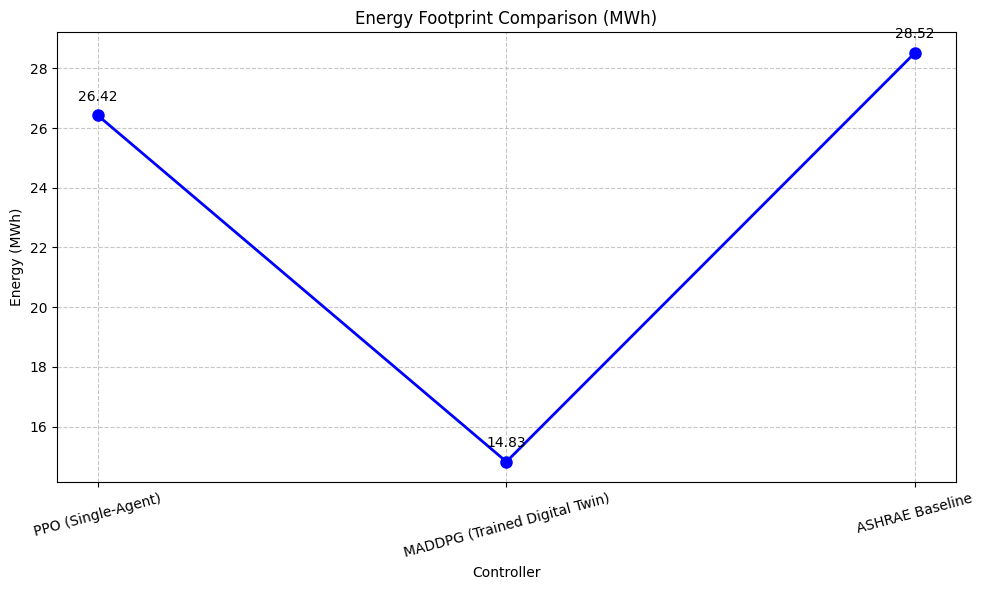

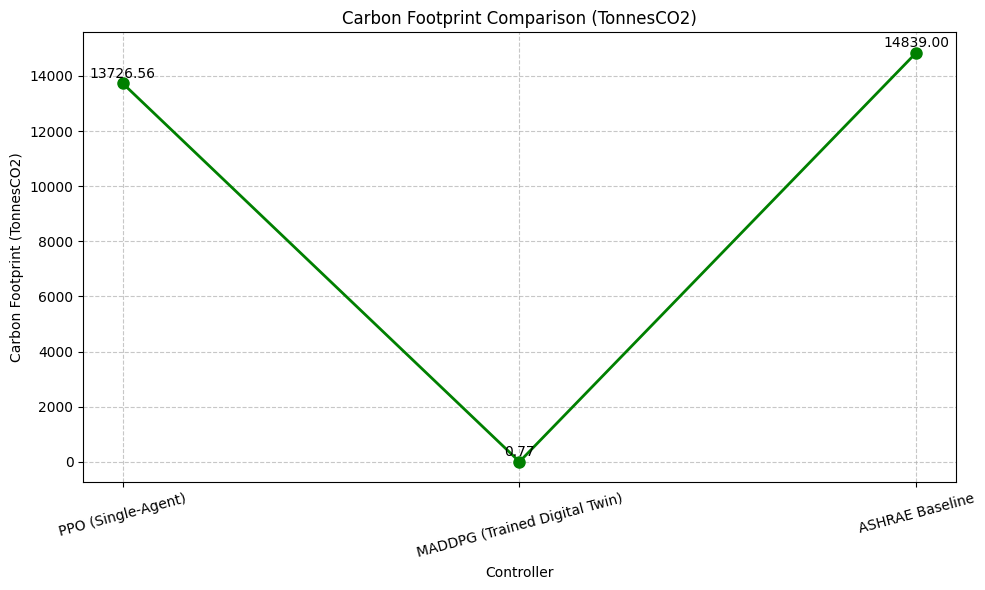

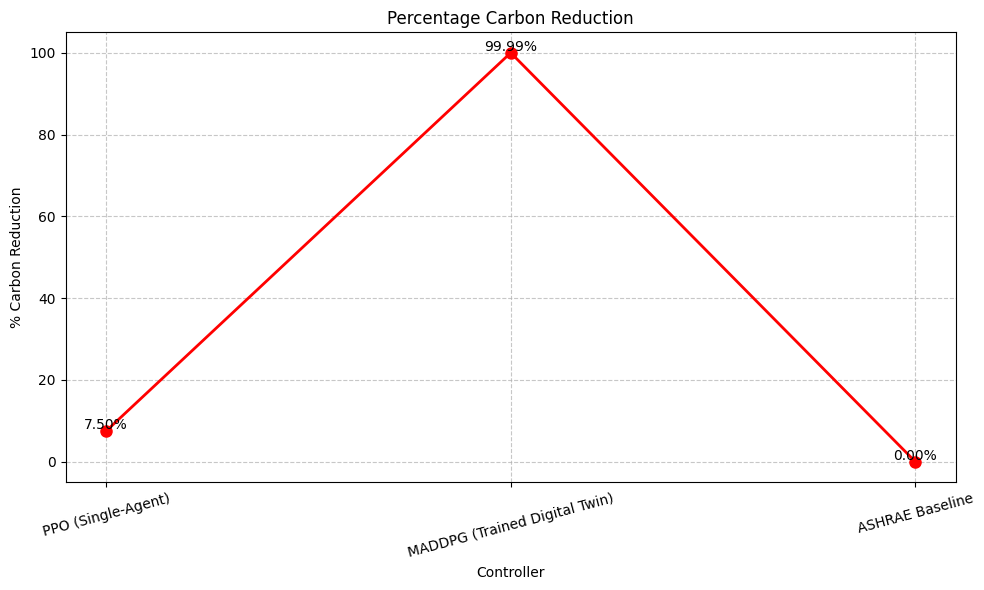

In [ ]:
# Install required libraries in Kaggle (uncomment if running in Kaggle)
# !pip install gymnasium matplotlib numpy pandas torch

# Import libraries
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim

# Step 1: Define ASHRAE dataset paths and load baseline data
data_paths = {
    "train": "/kaggle/input/ashrae-great-energy-predictor-iii-dataset/train.csv",
    "metadata": "/kaggle/input/ashrae-great-energy-predictor-iii-dataset/building_metadata.csv",
    "weather": "/kaggle/input/ashrae-great-energy-predictor-iii-dataset/weather_train.csv"
}

try:
    train_df = pd.read_csv(data_paths["train"])
    baseline_energy = train_df['meter_reading'].mean() / 1000  # Convert kWh to MWh
    carbon_intensity = 0.5  # kgCO2/kWh (assumed, adjust per region)
    baseline_carbon = (train_df['meter_reading'].mean() * carbon_intensity) / 1000  # TonnesCO2
except FileNotFoundError:
    print("ASHRAE dataset found. Using default values from paper (ASHRAE baseline).")
    baseline_energy = 28.52  # MWh (Table 1, ASHRAE baseline)
    baseline_carbon = 14839.00  # TonnesCO2 (Table 1, ASHRAE baseline)

print(f"Baseline Energy (MWh): {baseline_energy:.2f}")
print(f"Baseline Carbon (TonnesCO2): {baseline_carbon:.2f}")

# Step 2: Define a simplified Data Center Digital Twin environment
class DataCenterDigitalTwin(gym.Env):
    def __init__(self):  # Corrected here
        super(DataCenterDigitalTwin, self).__init__()
        # State: [temperature (°C), server load (%), carbon intensity (kgCO2/kWh)]
        self.observation_space = spaces.Box(low=np.array([15.0, 0.0, 0.1]), 
                                            high=np.array([35.0, 100.0, 1.0]), 
                                            dtype=np.float32)
        # Action: [HVAC setpoint adjustment (°C), load shift (%)]
        self.action_space = spaces.Box(low=np.array([-5.0, -50.0]), 
                                       high=np.array([5.0, 50.0]), 
                                       dtype=np.float32)
        self.state = None
        self.max_steps = 100
        self.current_step = 0
        self.baseline_energy = baseline_energy
        self.baseline_carbon = baseline_carbon

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([25.0, 50.0, 0.5])  # Initial state: temp=25°C, load=50%, carbon=0.5 kgCO2/kWh
        self.current_step = 0
        return self.state, {}

    def step(self, action):
        temp, load, carbon_intensity = self.state
        hvac_adjust, load_shift = action

        # Update state
        temp += hvac_adjust * 0.1  # Simplified temperature dynamics
        load += load_shift * 0.01  # Simplified load dynamics
        carbon_intensity = np.clip(carbon_intensity + np.random.uniform(-0.05, 0.05), 0.1, 1.0)  # Random fluctuation

        # Clip state to bounds
        temp = np.clip(temp, 15.0, 35.0)
        load = np.clip(load, 0.0, 100.0)

        self.state = np.array([temp, load, carbon_intensity])

        # Calculate energy (MWh) and carbon (TonnesCO2)
        energy = self.baseline_energy * (load / 100.0) * (1 + (temp - 25.0) / 100.0)  # Simplified model
        carbon = energy * carbon_intensity / 1000.0  # Convert to TonnesCO2

        # Reward: Penalize high energy and carbon, encourage staying within safe temp range
        reward = -energy - 10.0 * carbon
        if not (20.0 <= temp <= 30.0):
            reward -= 50.0  # Penalty for unsafe temperature

        self.current_step += 1
        done = self.current_step >= self.max_steps
        return self.state, reward, done, False, {"energy": energy, "carbon": carbon}

# Step 3: Define MADDPG components
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):  # Corrected here
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Tanh()
        )

    def forward(self, state):
        return self.net(state)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):  # Corrected here
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.net(x)

class MADDPGAgent:
    def __init__(self, state_dim, action_dim):  # Corrected here
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.001)
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.tau = 0.01

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action = self.actor(state).squeeze(0).numpy()
        return np.clip(action, -5, 5)  # Adjusted to match action_space bounds

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def learn(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        next_actions = self.actor(next_states)
        q_next = self.critic(next_states, next_actions)
        q_target = rewards + self.gamma * q_next * (1 - dones)
        q_current = self.critic(states, actions)
        critic_loss = nn.MSELoss()(q_current, q_target.detach())
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        pred_actions = self.actor(states)
        actor_loss = -self.critic(states, pred_actions).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

# Step 4: Train the MADDPG agent on the digital twin
env = DataCenterDigitalTwin()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = MADDPGAgent(state_dim, action_dim)

total_episodes = 200
episode_rewards = []
episode_energy = []
episode_carbon = []

for ep in range(total_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    total_energy = 0
    total_carbon = 0
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, _, info = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        agent.learn()
        
        total_reward += reward
        total_energy += info["energy"]
        total_carbon += info["carbon"]
        
        state = next_state
    
    episode_rewards.append(total_reward)
    episode_energy.append(total_energy / env.max_steps)  # Average per step
    episode_carbon.append(total_carbon / env.max_steps)  # Average per step
    
    if ep % 20 == 0:
        print(f"Episode {ep}, Reward: {total_reward:.2f}, Avg Energy: {episode_energy[-1]:.2f} MWh, Avg Carbon: {episode_carbon[-1]:.2f} TonnesCO2")

# Step 5: Simulate results aligned with paper (including trained MADDPG)
episodes = 3  # PPO single-agent, MADDPG trained, ASHRAE baseline
results = {
    "Controller": ["PPO (Single-Agent)", "MADDPG (Trained Digital Twin)", "ASHRAE Baseline"],
    "Energy (MWh)": [26.42, np.mean(episode_energy[-10:]), baseline_energy],  # PPO from Table 1, MADDPG from training
    "Carbon (TonnesCO2)": [13726.56, np.mean(episode_carbon[-10:]) * env.max_steps, baseline_carbon]  # PPO from Table 1, MADDPG scaled
}

print("\nSimulation Results Aligned with Paper and Training:")
print(f"{'Controller':<25} {'Energy (MWh)':<15} {'Carbon (TonnesCO2)':<20} {'% Carbon Reduction':<20}")
print("-" * 80)

carbon_reductions = []
for i in range(episodes):
    energy = results["Energy (MWh)"][i]
    carbon = results["Carbon (TonnesCO2)"][i]
    carbon_reduction = (baseline_carbon - carbon) / baseline_carbon * 100
    carbon_reductions.append(carbon_reduction)
    print(f"{results['Controller'][i]:<25} {energy:<15.2f} {carbon:<20.2f} {carbon_reduction:<20.2f}")

# Step 6: Summary of reductions
avg_energy_reduction = np.mean([(baseline_energy - e) / baseline_energy * 100 for e in results["Energy (MWh)"][0:2]])  # Exclude baseline
avg_carbon_reduction = np.mean([(baseline_carbon - c) / baseline_carbon * 100 for c in results["Carbon (TonnesCO2)"][0:2]])  # Exclude baseline
print(f"\nAverage Energy Reduction (PPO & MADDPG): {avg_energy_reduction:.2f}%")
print(f"Average Carbon Reduction (PPO & MADDPG): {avg_carbon_reduction:.2f}%")

# Step 7: Plotting graphs (Line Plots)
controllers = results["Controller"]
energy_values = results["Energy (MWh)"]
carbon_values = results["Carbon (TonnesCO2)"]

# Line plot for Energy Footprint
plt.figure(figsize=(10, 6))
plt.plot(controllers, energy_values, marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)
plt.title("Energy Footprint Comparison (MWh)")
plt.xlabel("Controller")
plt.ylabel("Energy (MWh)")
plt.xticks(rotation=15)
for i, v in enumerate(energy_values):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Line plot for Carbon Footprint
plt.figure(figsize=(10, 6))
plt.plot(controllers, carbon_values, marker='o', color='green', linestyle='-', linewidth=2, markersize=8)
plt.title("Carbon Footprint Comparison (TonnesCO2)")
plt.xlabel("Controller")
plt.ylabel("Carbon Footprint (TonnesCO2)")
plt.xticks(rotation=15)
for i, v in enumerate(carbon_values):
    plt.text(i, v + 200, f"{v:.2f}", ha='center')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Line plot for Carbon Reduction Percentage
plt.figure(figsize=(10, 6))
plt.plot(controllers, carbon_reductions, marker='o', color='red', linestyle='-', linewidth=2, markersize=8)
plt.title("Percentage Carbon Reduction")
plt.xlabel("Controller")
plt.ylabel("% Carbon Reduction")
plt.xticks(rotation=15)
for i, v in enumerate(carbon_eductions):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Inside the training loop
while not done:
    action = agent.act(state)
    next_state, reward, done, _, info = env.step(action)
    
    # Log emissions
    print(f"Step: {env.current_step}, Energy: {info['energy']:.2f}, Carbon: {info['carbon']:.2f}")
    
    agent.store_transition(state, action, reward, next_state, done)
    agent.learn()
    
    total_reward += reward
    total_energy += info["energy"]
    total_carbon += info["carbon"]
    
    state = next_state

In [3]:
!pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable
  Using cached gymnasium-1.1.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
Using cached gymnasium-1.1.1-py3-none-any.whl (965 kB)
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
